In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision.models import resnet50
from torchvision.transforms import Compose, ToTensor, Resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

from PIL import Image

import os
import random

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [3]:
train_path = os.path.join("..", "input", "data", "train")
eval_path = os.path.join("..", "input", "data", "eval")

In [4]:
df_train = pd.read_csv(os.path.join(train_path, "train.csv"))
df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))

In [5]:
class MaskDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        all_images = []
        for path in df_train["path"]:
            image_path = os.path.join(train_path, "images", path)
            all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]

        self.categories = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}
        self.transform = transform

        category = []
        class_masked = []
        class_sex = []
        class_age = []
        for image_filename in all_images:
            *_, person_info, mask_info = image_filename.split(os.sep)
            id, sex, _, age = person_info.split('_')
            age = int(age)
            if mask_info[:-4] == "normal":
                mask_info = "NotWear"
            elif mask_info[:-4] == "incorrect_mask":
                mask_info = "Incorrect"
            else:
                mask_info = "Wear"
            
            if age < 30:
                age = "Under30"
            elif age >= 60:
                age = "Overeq60"
            else:
                age = "30to60"
                
            category.append(self.categories[mask_info+sex+age])
            
            class_masked.append(mask_info)
            class_sex.append(sex)
            class_age.append(age)
            
        self.train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
        # self.train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]
        self.train_Xy = self.train_Xy.to_numpy()
        
    def __getitem__(self, idx):
        image = Image.open(self.train_Xy[idx][0])
        if self.transform:
            image = self.transform(image)
        label = self.train_Xy[idx][1]
        return image, label

    def __len__(self):
        return len(self.train_Xy)

In [6]:
class MaskDatasetEval(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))
        self.eval_image_path = os.path.join(eval_path, "images")
        self.transform = transform
        
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.eval_image_path, self.df_eval['ImageID'][idx]))
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.df_eval)

In [7]:
ds = MaskDataset(transform=Compose([ToTensor()]))
ds_eval = MaskDatasetEval(transform=Compose([ToTensor()]))

In [8]:
# train_ds, test_ds = train_test_split(ds, test_size=0.2, stratify=list(range(18)))
train_ds, valid_ds = random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.2)])

In [9]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

In [42]:
model = resnet50(pretrained=True)
# efficientnet은 성능이 많이 튄다고 함.
model.fc = nn.Linear(in_features=2048, out_features=18)

device = "cuda" if torch.cuda.is_available() else "cpu"

epoch = 10
patience = 5
best_loss = np.inf
counter = 0

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

for i in range(epoch):
    print(f"epoch {i+1}")
    model.train()
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_onehot = pred.argmax(dim=1)
        acc += sum(pred_onehot == y) / X.shape[0]
        total_loss += loss.item()
        
        if pred_list is not None:
            pred_list = torch.cat((pred_list, pred_onehot))
            y_list = torch.cat((y_list, y))
        else:
            pred_list = pred_onehot
            y_list = y
    print(f"train loss : {total_loss/len(train_dataloader)}, acc : {acc/len(train_dataloader) * 100}%", end=" ")
    print("f1 score : ", f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted'))
    
    model.eval()
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    with torch.no_grad():
        for X, y in tqdm(valid_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            pred_onehot = pred.argmax(dim=1)
            loss = loss_fn(pred, y).item()
            acc += sum(pred_onehot == y) / X.shape[0]
            total_loss += loss
            
            if pred_list is not None:
                pred_list = torch.cat((pred_list, pred_onehot))
                y_list = torch.cat((y_list, y))
            else:
                pred_list = pred_onehot
                y_list = y
    total_loss = total_loss/len(valid_dataloader)
    print(f"val loss : {total_loss}, acc : {acc/len(valid_dataloader) * 100}%", end=" ")
    print("f1 score : ", f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted'))
    
    torch.save({
        "epoch": i,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "earlystop_bestloss": best_loss,
        "earlystop_counter": counter,
        "train_losslist": train_loss_list,
        "val_losslist": val_loss_list,
        "val_metrics": val_metric_list
    })
    
    if best_loss > total_loss:
        print(f"validation loss improved. {best_loss}->{total_loss}")
        best_loss = total_loss
        couter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"No validation improvement until {patience} iteration. Stopping.")
    

epoch 1



train loss : 0.6050893028377223, acc : 84.11679077148438% f1 score :  0.827249588259534



val loss : 0.22068728222432782, acc : 92.77012634277344% f1 score :  0.9129078668321612
epoch 2



train loss : 0.13727971681362114, acc : 96.31224060058594% f1 score :  0.9618812671300125



val loss : 0.12227701750915435, acc : 95.78919219970703% f1 score :  0.9544062009522466
epoch 3



train loss : 0.04714319495271134, acc : 99.14591979980469% f1 score :  0.9914418618389228



val loss : 0.07261669128280827, acc : 97.59004211425781% f1 score :  0.975877902652713
epoch 4



train loss : 0.025265316999817298, acc : 99.56303405761719% f1 score :  0.995627683011979



val loss : 0.03781169766789081, acc : 98.80826568603516% f1 score :  0.9880144360238492
epoch 5



train loss : 0.019279694530947165, acc : 99.64910125732422% f1 score :  0.9964881334660173



val loss : 0.07144302315418057, acc : 97.98728942871094% f1 score :  0.9785027168495554
epoch 6



train loss : 0.02659093326014877, acc : 99.34454345703125% f1 score :  0.9934434658496553



val loss : 0.051099399726253825, acc : 98.41101837158203% f1 score :  0.9838336101878795
epoch 7



train loss : 0.015939416908175623, acc : 99.6424789428711% f1 score :  0.9964249890520327



val loss : 0.03323273973685484, acc : 99.02012634277344% f1 score :  0.9901606177240321
epoch 8



train loss : 0.014815908685766587, acc : 99.66233825683594% f1 score :  0.9966244253995786



val loss : 0.03796726728392907, acc : 98.75529479980469% f1 score :  0.9874292032188264
epoch 9



train loss : 0.0110428565480476, acc : 99.78150939941406% f1 score :  0.9978125393573875



val loss : 0.05455883996170488, acc : 98.41101837158203% f1 score :  0.9834791448369301
epoch 10



train loss : 0.01786048406803136, acc : 99.48358154296875% f1 score :  0.9948318695374166



val loss : 0.10865670911991432, acc : 96.63665008544922% f1 score :  0.9662562027299122


In [45]:
os.makedirs("saved", exist_ok=True)
torch.save(model.state_dict(), os.path.join("saved", "baseline.pt"))

In [10]:
checkpoint = torch.load(os.path.join("saved", "baseline.pt"))

In [12]:
model = resnet50(pretrained=True)
# efficientnet은 성능이 많이 튄다고 함.
model.fc = nn.Linear(in_features=2048, out_features=18)

In [16]:
model.load_state_dict(checkpoint())

<All keys matched successfully>

In [22]:
ds_eval[0].shape

torch.Size([3, 512, 384])

In [17]:
input, target = next(iter(valid_dataloader))

In [47]:
with torch.no_grad():
    pred = model(input.cuda())

In [48]:
pred = pred.argmax(dim=1)

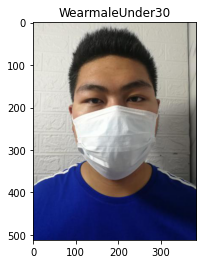

In [38]:
batch_idx = 4
label = list(ds.categories.keys())[pred[batch_idx]]
plt.title(label)
plt.imshow(input[batch_idx].permute(1, 2, 0))


In [39]:
target = []
prediction = []
with torch.no_grad():
    for X, y in valid_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        target.append(y.cpu().numpy())
        prediction.append(pred.cpu().numpy())

In [40]:
np.unique(np.array(prediction).argmax(axis=2))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [41]:
np.unique(np.array(prediction))

array([-19.305578, -19.226582, -18.791616, ...,  21.229116,  21.946497,
        22.272911], dtype=float32)